# Modèle 3 : Rétroaction glace-albédo et Terre "boule de neige"

## Présentation

## Le modèle 1 : "effet de l'albédo sur Terre"

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colorbar, colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

f1 = 'data/alpha_03_2000.txt'
f2 = 'data/alpha_03_2001.txt'
f3 = 'data/alpha_03_2002.txt'
f4 = 'data/alpha_03_2003.txt'
f5 = 'data/alpha_03_2004.txt'
f6 = 'data/alpha_03_2005.txt'


class AlbedoEffect() :

    def __init__(self, filename):
        self.name = filename
        self.alpha = self.getAlbedo()
        Teq1, Teq2 = self.evalTeq()
        self.Teq1 = Teq1
        self.Teq2 = Teq2
        del Teq1, Teq2


    def getAlbedo(self) :
        f = open(self.name,'r')
        alpha = np.genfromtxt(f,delimiter=',')
        alphax = ma.masked_values(alpha,99999.)
        # alpha[np.where(alpha == 99999.)] = 0.25
        return alphax

    def evalTeq(self) :
        # Evalue la température d'équilibre sans et avec effet de serre

        alpha = self.alpha

        # Paramètres physiques
        L = 1350                   # Constante solaire
        Is = (1 - alpha) * L / 4   # Flux solaire incident(en surface)
        eps = 1                    # Emissivité atmosphérique
        sigma = 5.67 * 10 **(-8)   # Constante de Stefan - Boltzman

        # Températures d'équilibre isotherme
        Teq1 = (Is / (eps * sigma))**(1/4) - 273.15         # sans effet de serre
        Teq2 = (Is / (1 - eps / 2) / sigma)**(1/4) - 273.15 # avec effet de serre (pour 1 vitre)

        return Teq1, Teq2

    def intTeq(self) :
        # Calcule la température transitoire avant l'atteinte d'équilibre

        alpha = self.alpha

        # Paramètres
        L = 1350.                  # Constante solaire
        Is = (1 - alpha) * L / 4   # Flux solaire incident(en surface)
        sigma = 5.67 * 10 ** (-8)  # Constante de Stefan - Boltzman
        eps = 1                    # Emissivité atmosphérique
        Cp = 4. * 10**6 * 4000

        timeStep = 100

        # Initialisation
        Ts1 = [np.zeros((180,360))]
        Ts2 = [np.zeros((180,360))]

        heatIn = Is
        heatOut1 = np.zeros((180,360))
        heatOut2 = np.zeros((180,360))

        heatContent1 = heatIn - heatOut1
        heatContent2 = heatIn - heatOut2

        Nglass = 2 ; # pour 1 vitre

        # Intégration
        for it in range(1,100):

            heatOut1 = eps * sigma * Ts1[it - 1] ** 4
            heatContent1 = heatContent1 + (heatIn - heatOut1) * (timeStep * 3.14 * 10 ** 7)
            Ts1.append(heatContent1 / Cp)

            heatOut2 = eps * sigma * Ts2[it - 1] ** 4 / Nglass
            heatContent2 = heatContent2 + (heatIn - heatOut2) * (timeStep * 3.14 * 10 ** 7)
            Ts2.append(heatContent2 / Cp)

        for it in range(0,100):
            Ts1[it] = Ts1[it] - 273.15
            Ts2[it] = Ts2[it] - 273.15

        return Ts1[-1], Ts2[-1]

    def mapTs(self, id=1):

        # Cartographie la température d'équilibre sans ou avec effet de serre
        # id = 1 -> pas d'effet de serre
        # id = 2 -> avec effet de serre

        Ts1, Ts2 = self.intTeq()

        if id == 1 :
            Ts = Ts1
            str = 'Sans effet de serre'
        else :
            Ts = Ts2
            str = 'Avec effet de serre'

        fig = plt.figure()

        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_title(str + ' : Ts moyenne = ' + np.str(np.int(np.nanmean(Ts))) + ' °C',fontsize=12, fontweight='bold')
        lats = np.arange(-180, 180, 1)
        lons = np.arange(-90, 90, 1)
        p = ax.pcolor(lats, lons, Ts[::-1], cmap='coolwarm', transform=ccrs.PlateCarree(),
                      vmin=-100,vmax=45)
        fig.colorbar(p, ax=ax, orientation='horizontal',shrink=0.8)
        ax.coastlines()

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.2, linestyle='-')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}

        fig.show()

## Application

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:130: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


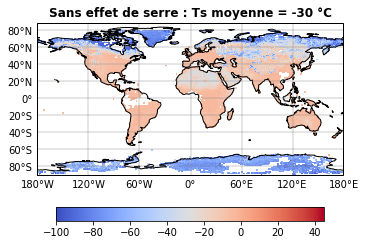

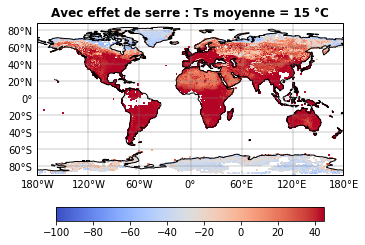

In [2]:
m1 = AlbedoEffect(f1)
m1.mapTs(1)
m1.mapTs(2)

# Le modèle : "Terre boule de neige"

In [3]:
import numpy
import matplotlib.pyplot as plt

def IceAlbedoFeedback(albedo=0.4,Lmin=1200,Lmax=1600):

  # PARAMETERS
  nTime = 100
  mIce = 1.5
  bIce = 322.5
  mAlbedo = -0.01
  bAlbedo = 2.8
  LRange = [Lmin , Lmax]
  epsilon = 1
  sigma = 5.67E-8

  # INITIALIZATION
  # L starts at the highest value => we simulate a surface cooling
  L = LRange[1]

  LValues = []
  temperatureValues = []
  albedoValues = []
  iceLatitudeValues = []

  while L > LRange[0] - 1:
    for iTime in range(0,nTime):
      temperature = L * (1-albedo)/(4*epsilon*sigma)
      temperature = temperature**(1/4)
      albedo = mAlbedo * temperature + bAlbedo
      iceLatitude = mIce * temperature + bIce
      # Limits
      albedo = max(0.15,albedo)
      albedo = min(albedo,0.65)
      iceLatitude = max(0,iceLatitude)
      iceLatitude = min(iceLatitude,90)
    # Lists
    LValues.append(L)
    temperatureValues.append(temperature)
    albedoValues.append(albedo)
    iceLatitudeValues.append(iceLatitude)
    L = L - 10

  # then a warming !
  while L < LRange[1]:
    for iTime in range(0,nTime):
      temperature = L * (1-albedo)/(4*epsilon*sigma)
      temperature = temperature**(1/4)
      albedo = mAlbedo * temperature + bAlbedo
      iceLatitude = mIce * temperature + bIce
      # Limits
      albedo = max(0.15,albedo)
      albedo = min(albedo,0.65)
      iceLatitude = max(0,iceLatitude)
      iceLatitude = min(iceLatitude,90)
    # Lists
    LValues.append(L)
    temperatureValues.append(temperature)
    albedoValues.append(albedo)
    iceLatitudeValues.append(iceLatitude)
    L = L + 10

  return LValues, temperatureValues



## Application

In [4]:
LValues, temperatureValues = IceAlbedoFeedback(0.1,1000,2000)

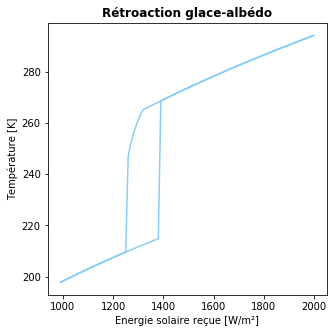

In [5]:
# Figure
plt.figure(figsize=(5,5))
plt.title('Rétroaction glace-albédo',fontweight='bold')
plt.plot(LValues,temperatureValues,color='lightskyblue')
plt.xlabel('Energie solaire reçue [W/m²]')
plt.ylabel('Température [K]')
plt.show()